In [4]:
import os

# 指定文件夹路径
exception_save_path = '../Dataset/Exception_Data'
plt_save_path = '../result/WSHR/figures'

# 获取文件夹下的所有文件名称
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

In [42]:
# 读取异常文件，捕捉异常时段，生成统计分布
from scipy.io import loadmat
import numpy as np

# 规定WSHR异常值
wshr_e_value = 0

# 初始化WSHR异常时间字典，分为前半段和后半段
wshr_warn_time_dict = {}
wshr_warn_time_dict_f, wshr_warn_time_dict_b = {}, {}

for e_folder_path in exception_folder_paths:
    # 读取当前异常文件夹下所有文件路径
    e_mat_paths = [os.path.join(e_folder_path, item) for item in os.listdir(e_folder_path) if item.endswith('.mat')]
    for e_mat_path in e_mat_paths:
        # 读取当前异常文件
        e_mat = loadmat(e_mat_path)

        # 捕捉WSHR变量值为异常的时间段
        wshr = e_mat['WSHR']
        wshr_data, wshr_rate = wshr[0][0][0], wshr[0][0][1][0][0]
        # print(len(wshr_data))
        # wshr_warn_time_list = [t if t<=len(wshr_data)/2 else t-len(wshr_data) for t in np.where(wshr_data==wshr_e_value)[0]]
        wshr_warn_time_list = [t for t in np.where(wshr_data==wshr_e_value)[0]]
        wshr_warn_time_list_f, wshr_warn_time_list_b = [], []
        for t in np.where(wshr_data==wshr_e_value)[0]:
            if t <= len(wshr_data)/2:
                wshr_warn_time_list_f.append(t)
            else:
                wshr_warn_time_list_b.append(t-int(len(wshr_data)/2))
        
        e_mat_marker = e_mat_path.split('\\')[-2] + '/' + e_mat_path.split('\\')[-1]

        wshr_warn_time_dict[e_mat_marker] = wshr_warn_time_list
        wshr_warn_time_dict_f[e_mat_marker] = wshr_warn_time_list_f
        wshr_warn_time_dict_b[e_mat_marker] = wshr_warn_time_list_b
#     break
# break

In [6]:
wshr_len_list = []
for e_folder_path in exception_folder_paths:
    # 读取当前异常文件夹下所有文件路径
    e_mat_paths = [os.path.join(e_folder_path, item) for item in os.listdir(e_folder_path) if item.endswith('.mat')]
    for e_mat_path in e_mat_paths:
        # 读取当前异常文件
        e_mat = loadmat(e_mat_path)

        # 捕捉WSHR变量值为异常的时间段
        wshr = e_mat['WSHR']
        wshr_data, wshr_rate = wshr[0][0][0], wshr[0][0][1][0][0]

        wshr_len_list.append(len(wshr_data))

print(np.max(wshr_len_list), np.min(wshr_len_list), np.mean(wshr_len_list), np.median(wshr_len_list))

13620 4 2842.2923976608186 968.0


WSHR warns in [572 567 565] cases in total 3974 warn mats at: [0 1 2]


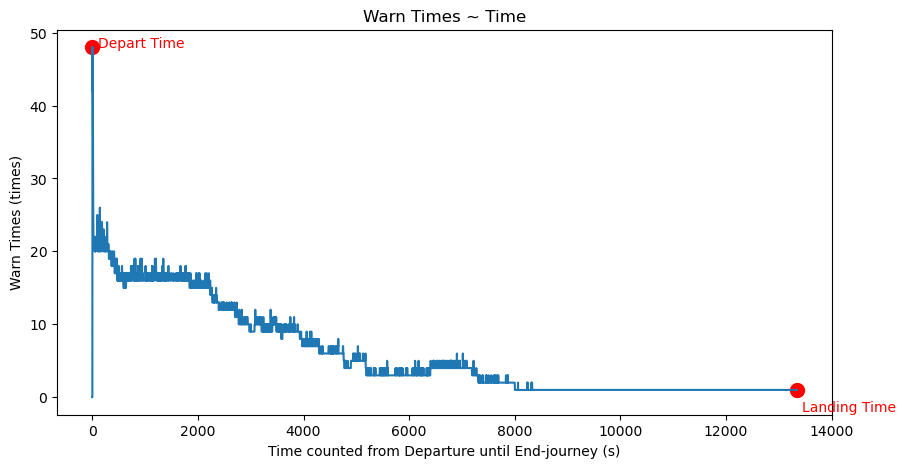

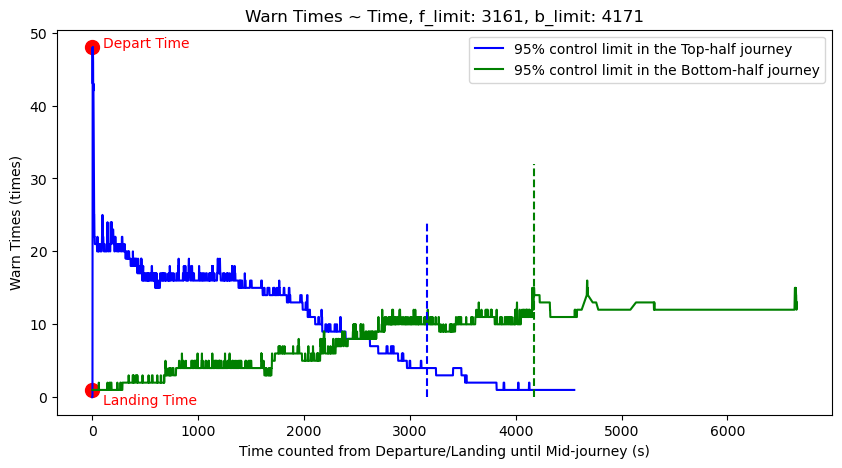

In [83]:
from collections import Counter
from matplotlib import pyplot as plt

# 初始化计数器
time_counter = Counter()
time_counter_f, time_counter_b = Counter(), Counter()

for e_mat_marker, e_warn_time_list in wshr_warn_time_dict.items():
    time_counter.update(Counter(e_warn_time_list))
for e_mat_marker, e_warn_time_list in wshr_warn_time_dict_f.items():
    time_counter_f.update(Counter(e_warn_time_list))
for e_mat_marker, e_warn_time_list in wshr_warn_time_dict_b.items():
    time_counter_b.update(Counter(e_warn_time_list))

sorted_indices = np.argsort(list(time_counter.keys()))
x_warn_time, y_times = np.array(list(time_counter.keys()))[sorted_indices], np.array(list(time_counter.values()))[sorted_indices]
sorted_indices_f = np.argsort(list(time_counter_f.keys()))
x_warn_time_f, y_times_f = np.array(list(time_counter_f.keys()))[sorted_indices_f], np.array(list(time_counter_f.values()))[sorted_indices_f]
sorted_indices_b = np.argsort(list(time_counter_b.keys()))
x_warn_time_b, y_times_b = np.array(list(time_counter_b.keys()))[sorted_indices_b], np.flip(np.array(list(time_counter_b.values()))[sorted_indices_b])

# 提出高频数异常时刻
# max_times_idx = np.where(y_times==np.max(y_times))[0]
max_times_idx = np.where(y_times_f > 500)[0]
# x_warn_time = np.delete(x_warn_time, max_times_idx)
# y_times = np.delete(y_times, max_times_idx)
print(f"WSHR warns in {y_times[max_times_idx]} cases in total {3974} warn mats at: {x_warn_time_f[max_times_idx]}")
y_times_f[max_times_idx] = 0
y_times[max_times_idx] = 0

# 航程开始/结束各自计算给定比例的时刻阈值
limit_percent = 0.95

f_half_times, b_half_times = np.sum(y_times_f), np.sum(y_times_b)
limit_f_times, limit_b_times = int(f_half_times * limit_percent), int(b_half_times * limit_percent)
count_f_times, count_b_times = 0, 0
limit_f_idx, limit_b_idx = 0, 0
for idx in range(len(x_warn_time_f)):
    count_f_times += y_times_f[idx]
    if count_f_times > limit_f_times:
        limit_f_idx = x_warn_time_f[idx]
        break
for idx in range(len(x_warn_time)):
    count_b_times += y_times_b[idx]
    if count_b_times > limit_b_times:
        limit_b_idx = x_warn_time_b[idx]
        break

# WSHR异常时间可视化
plt.figure(figsize=(10, 5))
plt.plot(x_warn_time, y_times)
plt.scatter(x_warn_time[0], max(y_times), color='red', marker='o', s=100)
plt.text(x_warn_time[0]+100, max(y_times), 'Depart Time', color='red')
plt.scatter(x_warn_time[len(x_warn_time)-1], y_times[len(y_times)-1], color='red', marker='o', s=100)
plt.text(x_warn_time[len(x_warn_time)-1]+100, min(y_times)-2, 'Landing Time', color='red')
plt.xlabel("Time counted from Departure until End-journey (s)")
plt.ylabel("Warn Times (times)")
plt.title(f"Warn Times ~ Time")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_warn_time_f, y_times_f, color='blue')
plt.plot(x_warn_time_b, y_times_b, color='green')
plt.scatter(x_warn_time_f[0], max(y_times_f), color='red', marker='o', s=100)
plt.text(x_warn_time_f[0]+100, max(y_times_f), 'Depart Time', color='red')
plt.scatter(x_warn_time_b[0], y_times_b[0], color='red', marker='o', s=100)
plt.text(x_warn_time_b[0]+100, y_times_b[0]-2, 'Landing Time', color='red')
plt.vlines(limit_f_idx, 0, np.max(y_times_f/2), colors='b', linestyles='--', label='f_limit')
plt.vlines(limit_b_idx, 0, np.max(y_times_b*2), colors='green', linestyles='--', label='b_limit')
plt.xlabel("Time counted from Departure/Landing until Mid-journey (s)")
plt.ylabel("Warn Times (times)")
plt.title(f"Warn Times ~ Time, f_limit: {limit_f_idx}, b_limit: {limit_b_idx}")
plt.legend(labels=['95% control limit in the Top-half journey', '95% control limit in the Bottom-half journey'])
plt.show()

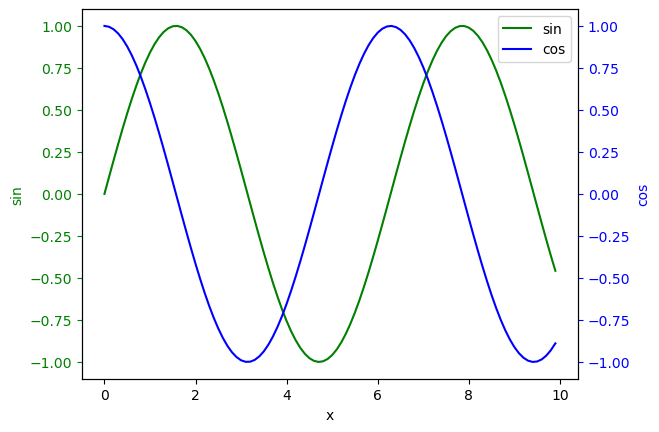

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 创建示例数据
x = np.arange(0, 10, 0.1)
y1 = np.sin(x)
y2 = np.cos(x)

# 创建图形和坐标轴
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # 创建第二套坐标轴

# 绘制第一套数据
ax1.plot(x, y1, 'g-', label='sin')
ax1.set_xlabel('x')
ax1.set_ylabel('sin', color='g')
ax1.tick_params('y', colors='g')

# 绘制第二套数据
ax2.plot(x, y2, 'b-', label='cos')
ax2.set_ylabel('cos', color='b')
ax2.tick_params('y', colors='b')

# 添加图例
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [line.get_label() for line in lines])

# 展示图表
plt.show()

